In [1]:
# Import packages
import os
import gzip
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

## Load data

In [2]:
def load_mnist(path="data", kind="train"):
    """Load MNIST data and unzip it."""
    if kind == "test":
        kind = "t10k"
    labels_path = os.path.join(path, "{}-labels-idx1-ubyte.gz".format(kind))
    images_path = os.path.join(path, "{}-images-idx3-ubyte.gz".format(kind))

    # Unzip data and read labels
    with gzip.open(labels_path, mode="rb") as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    # Unzip data and read imaged as a numpy array
    with gzip.open(images_path, mode="rb") as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)
    return images, labels

In [3]:
train_image, train_labels = load_mnist(path="data/", kind="train")

test_image, test_labels = load_mnist(path="data/", kind="test")

print(train_image.shape, train_labels.shape)
print(test_image.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [4]:
index_label_mapping = {
    0: "T-Shirt or Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

In [5]:
# Normalize pixel values
train_image = train_image / 255
test_image = test_image / 255

## Data lookup

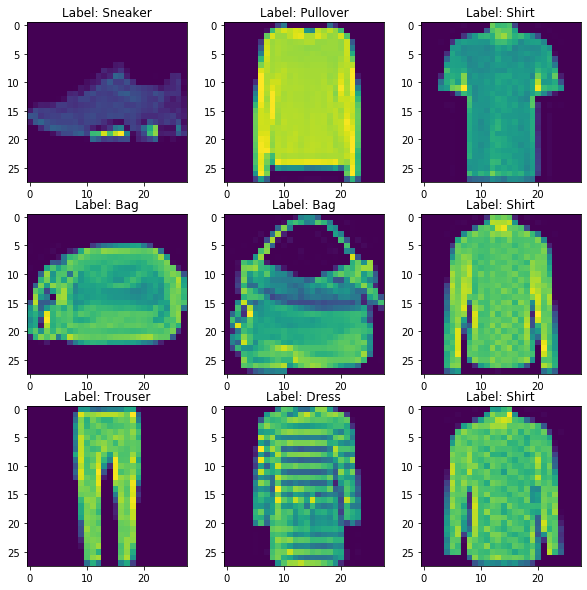

In [6]:
fig = plt.figure(figsize=(10, 10))
total_images = 9
num_rows = 3
num_cols = 3

for i in range(1, total_images + 1):
    randsom_idx = np.random.randint(0, train_image.shape[0])
    fig.add_subplot(num_rows, num_cols, i) # i cannot be 0
    plt.imshow(train_image[randsom_idx])
    lable = train_labels[randsom_idx]
    str_label = index_label_mapping[lable]
    plt.title("Label: {}".format(str_label))
plt.show()

In [7]:
# Reshape images to incorporate channels for model training
train_image = train_image.reshape((len(train_image), 28, 28, 1))

test_image = test_image.reshape((len(test_image), 28, 28, 1))

print(train_image.shape, test_image.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [8]:
# Make categorcial labels
train_labels = keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = keras.utils.to_categorical(test_labels, num_classes=10)

## Define models

In [9]:
class SmallVGG(keras.models.Model):
    """Small VGG like image classifier."""

    def __init__(self, num_classes, dense_layer_size=1024, activation="relu", output_activation="softmax", dp_rate=0.4):
        """Class constructor to initialise member variables.
        
        Arguments:
            num_classes {[type]} -- Number of prediction classes.
        
        Keyword Arguments:
            dense_layer_size {int} -- Number of nodes in the dense layer. (default: {1024})
            activation {str} -- Activation to be used in the hidden layers. (default: {relu})
            output_activation {str} -- Activation to be used with the output layer. (default: {softmax})
            dp_rate {float} -- Dropout ratio to be used. (default: {0.25})
        """
        super(SmallVGG, self).__init__()
        # Set member variables
        self.num_classes = num_classes
        self.dense_layer_size = dense_layer_size
        self.activation = activation
        self.output_activation = output_activation
        self.dp_rate = dp_rate
        # Define layers
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=self.activation)
        self.conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=self.activation)
        self.conv3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=self.activation)
        self.conv4 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=self.activation)
        self.pool1 = keras.layers.MaxPool2D(pool_size=(2, 2))
        self.pool2 = keras.layers.MaxPool2D(pool_size=(2, 2))
        self.dropout = keras.layers.Dropout(rate=dp_rate)
        self.flatten = keras.layers.Flatten()
        self.d1 = keras.layers.Dense(units=self.dense_layer_size, activation=self.activation)
        self.d2 = keras.layers.Dense(units=self.dense_layer_size, activation=self.activation)
        self.d3 = keras.layers.Dense(units=self.num_classes, activation=self.output_activation)

    def call(self, x):
        """Forward pass over the network.
        
        Returns:
            output -- Output tensor from the network.
        """
        # First convolution block
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Second convolution block
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout(x)

        # Classification layer
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

## Simple model trainer

In [10]:
classifier = SmallVGG(num_classes=10)

W0730 02:42:08.792324 139620787275584 deprecation.py:506] From /home/nityan/anaconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
classifier.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [12]:
classifier.build(input_shape=(None, 28, 28, 1))

In [13]:
classifier.summary()

Model: "small_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0 

In [14]:
classifier.fit(
    x=train_image, y=train_labels,
    validation_split=0.2,
    batch_size=256,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3)]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 3s 60us/sample - loss: 0.7954 - acc: 0.7038 - val_loss: 0.5116 - val_acc: 0.8101
Epoch 2/20
48000/48000 [==============================] - 1s 29us/sample - loss: 0.4438 - acc: 0.8356 - val_loss: 0.3657 - val_acc: 0.8645
Epoch 3/20
48000/48000 [==============================] - 1s 29us/sample - loss: 0.3607 - acc: 0.8670 - val_loss: 0.2954 - val_acc: 0.8903
Epoch 4/20
48000/48000 [==============================] - 1s 29us/sample - loss: 0.3233 - acc: 0.8814 - val_loss: 0.2793 - val_acc: 0.8995
Epoch 5/20
48000/48000 [==============================] - 1s 29us/sample - loss: 0.2968 - acc: 0.8907 - val_loss: 0.2596 - val_acc: 0.9058
Epoch 6/20
48000/48000 [==============================] - 1s 28us/sample - loss: 0.2819 - acc: 0.8964 - val_loss: 0.2697 - val_acc: 0.9018
Epoch 7/20
48000/48000 [==============================] - 1s 29us/sample - loss: 0.2679 - acc: 0.9019 - val_loss: 0.

In [15]:
classifier.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## Visualize model training

In [16]:
history = classifier.history.history

print(history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


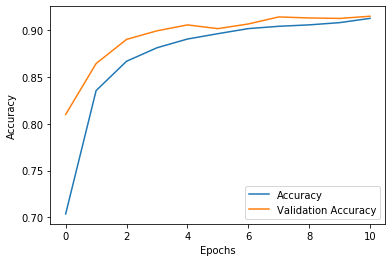

In [22]:
acc = history["acc"]
val_acc = history["val_acc"]

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()